In [27]:
"""
    Load training/val/test set
"""

from util import load_xyidst_threaded
from tabulate import tabulate
import numpy as np

DATA_FOLDER = "data_emanuel"
AGE = "greater"

source_folder_old = "data_emanuel/greaterthan7/dataset/preprocessed/"
source_folder_young = "data_emanuel/lessthan7/dataset/preprocessed/"
source_folder_all = "data_emanuel/all/dataset/preprocessed/"

f_low = 1.8
f_high = 13.0
fs = 500.0

age = "old"

if age == "young":
    source_folder = source_folder_young
elif age == "old":
    source_folder = source_folder_old
elif age == "combined":
    source_folder = source_folder_all

phase = "train/"
x, y, ids, erp_t, speed, bad_chs = load_xyidst_threaded(
    source_folder + phase, verbose=False, load_bad_ch=True
)

x_train_2d = x
x_train_2d[bad_chs] = 0
y_train = y
t_train = erp_t
t_train[y==0] = 0
speed_train = speed
ids_train = ids

phase = "val/"
x, y, ids, erp_t, speed, bad_chs = load_xyidst_threaded(
    source_folder + phase, verbose=False, load_bad_ch=True
)

x_val_2d = x
x_val_2d[bad_chs] = 0
y_val = y
t_val = erp_t
t_val[y==0] = 0
speed_val = speed
ids_val = ids

phase = "test/"
x, y, ids, erp_t, speed, bad_chs = load_xyidst_threaded(
    source_folder + phase, verbose=False, load_bad_ch=True
)

x_test_2d = x
x_test_2d[bad_chs] = 0
y_test = y
t_test = erp_t
t_test[y==0] = 0
speed_test = speed
ids_test = ids

print("Data sets loaded")
df = []
y_list = [y_train, y_val, y_test]
ids_list = [ids_train, ids_val, ids_test]
hdr = ["", "train", "val", "test"]

n_samples = ["n_samples"]
n_pos = ["n_pos"]
n_neg = ["n_neg"]
n_ids = ["n_ids"]
for i, y_ in enumerate(y_list):
    n_samples.append(y_.shape[0])
    n_neg.append(np.sum(y_ == 0))
    n_pos.append(np.sum(y_ == 1))
    n_ids.append(len(set(list(ids_list[i]))))

df.append(n_samples)
df.append(n_pos)
df.append(n_neg)
df.append(n_ids)


print(tabulate(df, hdr, tablefmt="presto"))

Data sets loaded
           |   train |   val |   test
-----------+---------+-------+--------
 n_samples |     270 |    75 |    112
 n_pos     |     270 |    75 |    112
 n_neg     |       0 |     0 |      0
 n_ids     |      30 |     9 |     11


In [28]:

x_train_tmp, y_train_tmp, t_train_tmp, speed_train_tmp, ids_train_tmp = x_train_2d, y_train, t_train, speed_train, ids_train
x_val_tmp, y_val_tmp, t_val_tmp, speed_val_tmp, ids_val_tmp = x_val_2d, y_val, t_val, speed_val, ids_val
x_test_tmp, y_test_tmp, t_test_tmp, speed_test_tmp, ids_test_tmp = x_test_2d, y_test, t_test, speed_test, ids_test

In [29]:
"""
    Select speed(s)
"""

def filter_dataset(x, y, t, speed, ids, filt_arr, accepted_values):
    mask = np.zeros(filt_arr.shape, dtype=bool)
    for val in accepted_values:
        mask = np.logical_or(mask, filt_arr == val)
    
    return x[mask], y[mask], t[mask], speed[mask], ids[mask]

In [30]:
ACCEPTED_VALS = [2,3,4]

x_train_2d, y_train, t_train, speed_train, ids_train = filter_dataset(x_train_tmp, y_train_tmp, t_train_tmp, speed_train_tmp, ids_train_tmp, speed_train_tmp, ACCEPTED_VALS)
x_val_2d, y_val, t_val, speed_val, ids_val = filter_dataset(x_val_tmp, y_val_tmp, t_val_tmp, speed_val_tmp, ids_val_tmp, speed_val_tmp, ACCEPTED_VALS)
x_test_2d, y_test, t_test, speed_test, ids_test = filter_dataset(x_test_tmp, y_test_tmp, t_test_tmp, speed_test_tmp, ids_test_tmp, speed_test_tmp, ACCEPTED_VALS)

In [31]:
df = []
y_list = [y_train, y_val, y_test]
ids_list = [ids_train, ids_val, ids_test]
hdr = ["", "train", "val", "test"]

n_samples = ["n_samples"]
n_pos = ["n_pos"]
n_neg = ["n_neg"]
n_ids = ["n_ids"]
for i, y_ in enumerate(y_list):
    n_samples.append(y_.shape[0])
    n_neg.append(np.sum(y_ == 0))
    n_pos.append(np.sum(y_ == 1))
    n_ids.append(len(set(list(ids_list[i]))))

df.append(n_samples)
df.append(n_pos)
df.append(n_neg)
df.append(n_ids)


print(tabulate(df, hdr, tablefmt="presto"))

           |   train |   val |   test
-----------+---------+-------+--------
 n_samples |     270 |    75 |    112
 n_pos     |     270 |    75 |    112
 n_neg     |       0 |     0 |      0
 n_ids     |      30 |     9 |     11


In [32]:
def normalize(x):
    x_mu = np.nanmean(x, axis=1)
    x_std = np.nanstd(x, axis=1)
    x_norm = (np.swapaxes(x, 0, 1) - x_mu) / x_std
    return np.swapaxes(x_norm, 0, 1)

x_train_2d = normalize(x_train_2d)
x_val_2d = normalize(x_val_2d)
x_test_2d = normalize(x_test_2d)

In [33]:
print(x_test_2d.shape)

(112, 128, 500)


In [34]:
from montage import read_montage, transform_montage, transform_2d_to_3d, crop_montage

MONTAGE_FNAME = "GSN-HydroCel-128.sfp"
NX = 20
NY = 20
X_LOW, X_HIGH = 3, 18
Y_LOW, Y_HIGH = 0, 16
nt = x_train_2d.shape[2]

montage2d = transform_montage(read_montage(MONTAGE_FNAME), NX, NY)
print(montage2d.shape)


def transform_data_set(x, montage2d, nx, ny, xl, xh, yl, yh):
    nepochs = x.shape[0]
    nt = x.shape[2]
    x3d = np.zeros((nepochs, xh-xl, yh-yl, nt))
    for i in range(nepochs):
        tmp = transform_2d_to_3d(x[i], montage2d, nx, ny)
        x3d[i] = crop_montage(tmp, xl, xh, yl, yh)

    return x3d

x_train = transform_data_set(x_train_2d, montage2d, NX, NY, X_LOW, X_HIGH, Y_LOW, Y_HIGH)
x_val = transform_data_set(x_val_2d, montage2d, NX, NY, X_LOW, X_HIGH, Y_LOW, Y_HIGH)
x_test = transform_data_set(x_test_2d, montage2d, NX, NY, X_LOW, X_HIGH, Y_LOW, Y_HIGH)
print(x_train.shape)

(2, 128)
(270, 15, 16, 500)


In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], 1)
print(input_shape)

(15, 16, 500, 1)


In [36]:
reconstructed_model = keras.models.load_model("CNNmodels/model_old_net_065loss_65acc.h5")
reconstructed_model.summary()

Model: "model_223"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_232 (InputLayer)         [(None, 15, 14, 750  0           []                               
                                , 1)]                                                             
                                                                                                  
 max_pooling3d_352 (MaxPooling3  (None, 15, 14, 150,  0          ['input_232[0][0]']              
 D)                              1)                                                               
                                                                                                  
 conv3d_1024 (Conv3D)           (None, 5, 7, 30, 1)  31          ['max_pooling3d_352[0][0]']      
                                                                                          

In [37]:
"""
    old_net
"""
DROPOUT_RATE = 0.15

N_FILT1 = 1
N_FILT2 = 1
N_FILT3 = 2

N_NODES1 = 2
N_NODES2 = 2
N_NODES3 = 5 * N_NODES2

ACT_FUNC1 = layers.ELU # compare with ELU
ACT_FUNC2 = layers.ReLU

inputs = layers.Input(shape=input_shape)

x = layers.MaxPooling3D((1,1,5), strides=(1,1,5))(inputs)

x = layers.Conv3D(N_FILT1, (3,2,5), strides=(3,2,5), padding="same")(x)
x = ACT_FUNC1()(x)
x = layers.MaxPooling3D((2,2,5), strides=(1,1,5))(x)
x = layers.Dropout(DROPOUT_RATE)(x)

z = layers.AveragePooling3D((2,3,3), strides=(2,3,3))(x)
z = layers.Flatten()(z)
z = layers.Dropout(DROPOUT_RATE)(z)
z = layers.Dense(N_NODES3)(z)
z = ACT_FUNC2()(z)

vsrf = layers.Conv3D(N_FILT3, (1,1,10), strides=(1,1,10), padding="same")(x)
vsrf = layers.Dropout(DROPOUT_RATE)(vsrf)
vsrf = ACT_FUNC1()(vsrf)
vsrf = layers.Flatten()(vsrf)
vsrf = layers.Dense(N_NODES1)(vsrf)
vsrf = layers.Dropout(DROPOUT_RATE)(vsrf)
vsrf = ACT_FUNC2()(vsrf)
vsrf = layers.Dense(N_NODES2)(vsrf)

srf = layers.Conv3D(N_FILT3, (2,2,5), strides=(1,1,5), padding="same")(x)
srf = layers.Dropout(DROPOUT_RATE)(srf)
srf = ACT_FUNC1()(srf)
srf = layers.Flatten()(srf)
srf = layers.Dense(N_NODES1)(srf)
srf = layers.Dropout(DROPOUT_RATE)(srf)
srf = ACT_FUNC2()(srf)
srf = layers.Dense(N_NODES2)(srf)

mrf = layers.Conv3D(N_FILT3, (3,3,4), strides=(2,2,3), padding="same")(x)
mrf = layers.Dropout(DROPOUT_RATE)(mrf)
mrf = ACT_FUNC1()(mrf)
mrf = layers.Flatten()(mrf)
mrf = layers.Dense(N_NODES1)(mrf)
mrf = layers.Dropout(DROPOUT_RATE)(mrf)
mrf = ACT_FUNC2()(mrf)
mrf = layers.Dense(N_NODES2)(mrf)

lrf = layers.Conv3D(N_FILT3, (5,5,3), strides=(4,4,2), padding="same")(x)
lrf = layers.Dropout(DROPOUT_RATE)(lrf)
lrf = ACT_FUNC1()(lrf)
lrf = layers.Flatten()(lrf)
lrf = layers.Dense(N_NODES1)(lrf)
lrf = layers.Dropout(DROPOUT_RATE)(lrf)
lrf = ACT_FUNC2()(lrf)
lrf = layers.Dense(N_NODES2)(lrf)

vlrf = layers.Conv3D(N_FILT3, (7,7,2), strides=(6,6,1), padding="same")(x)
vlrf = layers.Dropout(DROPOUT_RATE)(vlrf)
vlrf = ACT_FUNC1()(vlrf)
vlrf = layers.Flatten()(vlrf)
vlrf = layers.Dense(N_NODES1)(vlrf)
vlrf = layers.Dropout(DROPOUT_RATE)(vlrf)
vlrf = ACT_FUNC1()(vlrf)
vlrf = layers.Dense(N_NODES2)(vlrf)

rfs = layers.Concatenate()([vsrf, srf, mrf, lrf, vlrf])
x = layers.Multiply()([rfs, z])

#x = layers.Concatenate()([vsrf, srf, mrf, lrf, vlrf, z])
x = layers.Dropout(DROPOUT_RATE)(x)

output = layers.Dense(1, activation="sigmoid", name="clf_output")(x)

old_net = keras.Model(inputs=inputs, outputs=output)

old_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 15, 16, 500  0           []                               
                                , 1)]                                                             
                                                                                                  
 max_pooling3d_4 (MaxPooling3D)  (None, 15, 16, 100,  0          ['input_4[0][0]']                
                                 1)                                                               
                                                                                                  
 conv3d_16 (Conv3D)             (None, 5, 8, 20, 1)  31          ['max_pooling3d_4[0][0]']        
                                                                                            

In [38]:
"""
    young_net
"""
DROPOUT_RATE1 = 0.5
DROPOUT_RATE2 = 0.5

N_FILT1 = 2
N_FILT2 = 4
N_FILT3 = 8

N_NODES1 = 8
N_NODES2 = 4
N_NODES3 = 4

inputs = layers.Input(shape=input_shape)

x = layers.MaxPooling3D((1,1,5), strides=(1,1,5))(inputs)

x = layers.Conv3D(N_FILT1, (3,3,4), strides=(1,1,2), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ELU()(x)

x = layers.Conv3D(N_FILT2, (3,3,3), strides=(2,2,2), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ELU()(x)

x = layers.Dropout(DROPOUT_RATE1)(x)

srf = layers.Conv3D(N_FILT3, (4,3,3), strides=(3,2,2), padding="same")(x)
srf = layers.BatchNormalization()(srf)
srf = layers.ELU()(srf)

srf = layers.Dropout(DROPOUT_RATE1)(srf)
srf = layers.Flatten()(srf)

srf = layers.Dense(N_NODES1)(srf)
srf = layers.BatchNormalization()(srf)
srf = layers.ReLU()(srf)

srf = layers.Dropout(DROPOUT_RATE2)(srf)

srf = layers.Dense(N_NODES2)(srf)

mrf = layers.Conv3D(N_FILT3, (4,3,4), strides=(2,2,2), padding="same")(x)
mrf = layers.BatchNormalization()(mrf)
mrf = layers.ELU()(mrf)

mrf = layers.Dropout(DROPOUT_RATE1)(mrf)
mrf = layers.Flatten()(mrf)

mrf = layers.Dense(N_NODES1)(mrf)
mrf = layers.BatchNormalization()(mrf)
mrf = layers.ReLU()(mrf)

mrf = layers.Dropout(DROPOUT_RATE2)(mrf)

mrf = layers.Dense(N_NODES2)(mrf)

lrf = layers.Conv3D(N_FILT3, (4,3,6), strides=(3,2,5), padding="same")(x)
lrf = layers.BatchNormalization()(lrf)
lrf = layers.ELU()(lrf)

lrf = layers.Dropout(DROPOUT_RATE1)(lrf)
lrf = layers.Flatten()(lrf)

lrf = layers.Dense(N_NODES1)(lrf)
lrf = layers.BatchNormalization()(lrf)
lrf = layers.ReLU()(lrf)

lrf = layers.Dropout(DROPOUT_RATE2)(lrf)

lrf = layers.Dense(N_NODES2)(lrf)

x = layers.Concatenate()([srf, mrf, lrf])

x = layers.Dense(N_NODES3)(x)
x = layers.ReLU()(x)
x = layers.Dropout(DROPOUT_RATE1)(x)

output_clf = layers.Dense(1, activation="sigmoid", name="clf_output")(x)

young_net = keras.Model(inputs=inputs, outputs=[output_clf])

young_net.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 15, 16, 500  0           []                               
                                , 1)]                                                             
                                                                                                  
 max_pooling3d_6 (MaxPooling3D)  (None, 15, 16, 100,  0          ['input_5[0][0]']                
                                 1)                                                               
                                                                                                  
 conv3d_22 (Conv3D)             (None, 15, 16, 50,   74          ['max_pooling3d_6[0][0]']        
                                2)                                                          

In [39]:
"""
    Tianjun_net
    Liu, T., Yang, D. A three-branch 3D convolutional neural network for EEG-based different hand movement stages classification. Sci Rep 11, 10758 (2021). https://doi.org/10.1038/s41598-021-89414-x
"""

DROPOUT_RATE = 0.2

N_FILT1 = 4
N_FILT2 = 8
N_FILT3 = 16

N_NODES1 = 8
N_NODES2 = 2

inputs = layers.Input(shape=input_shape)

x = layers.MaxPooling3D((1,1,5), strides=(1,1,5))(inputs)

x = layers.Conv3D(N_FILT1, (3,3,4), strides=(1,1,2), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ELU()(x)

x = layers.Conv3D(N_FILT2, (3,3,5), strides=(2,2,4), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ELU()(x)

x = layers.Dropout(DROPOUT_RATE)(x)

srf = layers.Conv3D(N_FILT3, (4,3,3), strides=(3,2,2), padding="same")(x)
srf = layers.BatchNormalization()(srf)
srf = layers.ELU()(srf)

srf = layers.Dropout(DROPOUT_RATE)(srf)
srf = layers.Flatten()(srf)

srf = layers.Dense(N_NODES1)(srf)
srf = layers.BatchNormalization()(srf)
srf = layers.ReLU()(srf)

srf = layers.Dropout(DROPOUT_RATE)(srf)

srf = layers.Dense(N_NODES2)(srf)

mrf = layers.Conv3D(N_FILT3, (4,3,4), strides=(2,2,2), padding="same")(x)
mrf = layers.BatchNormalization()(mrf)
mrf = layers.ELU()(mrf)

mrf = layers.Dropout(DROPOUT_RATE)(mrf)
mrf = layers.Flatten()(mrf)

mrf = layers.Dense(N_NODES1)(mrf)
mrf = layers.BatchNormalization()(mrf)
mrf = layers.ReLU()(mrf)

mrf = layers.Dropout(DROPOUT_RATE)(mrf)

mrf = layers.Dense(N_NODES2)(mrf)

lrf = layers.Conv3D(N_FILT3, (4,3,6), strides=(3,2,5), padding="same")(x)
lrf = layers.BatchNormalization()(lrf)
lrf = layers.ELU()(lrf)

lrf = layers.Dropout(DROPOUT_RATE)(lrf)
lrf = layers.Flatten()(lrf)

lrf = layers.Dense(N_NODES1)(lrf)
lrf = layers.BatchNormalization()(lrf)
lrf = layers.ReLU()(lrf)

lrf = layers.Dropout(DROPOUT_RATE)(lrf)

lrf = layers.Dense(N_NODES2)(lrf)

x = layers.Concatenate()([srf, mrf, lrf])

output_clf = layers.Dense(1, activation="sigmoid", name="clf_output")(x)
output_reg = layers.Dense(1, name="reg_output")(x)

tianjun_net = keras.Model(inputs=inputs, outputs=[output_clf, output_reg])

tianjun_net.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 15, 16, 500  0           []                               
                                , 1)]                                                             
                                                                                                  
 max_pooling3d_7 (MaxPooling3D)  (None, 15, 16, 100,  0          ['input_6[0][0]']                
                                 1)                                                               
                                                                                                  
 conv3d_27 (Conv3D)             (None, 15, 16, 50,   148         ['max_pooling3d_7[0][0]']        
                                4)                                                          

In [40]:
n_samples = y_train.shape[0]
w_clf = np.ones(n_samples)
w_reg = np.zeros(n_samples)
w_reg[y_train == 1] = 1

ops = {
    "optimizer": keras.optimizers.Adam(),
    "losses": {
        "clf_output": keras.losses.BinaryCrossentropy()
    },
    "loss_weights": {
        "clf_output": 0.5
    },
    "metrics": {
        "clf_output": [
            keras.metrics.BinaryAccuracy(),
            keras.metrics.PrecisionAtRecall(recall=0.8),
        ]
    },
    "y": {
        "clf_output": y_train,
    },
    "y_val": {
        "clf_output": y_val,
    },
    "sample_weight": {
        "clf_output": w_clf,
    },
}

model_dict = {
    "old_net": old_net,
    "young_net": young_net,
    "tianjun_net": tianjun_net,
}

In [41]:
n_epochs = 300

model_name = "young_net" if age ==  "young" else "old_net"
#model_name = "tianjun_net"
model = model_dict[model_name]

model.compile(
    optimizer = ops["optimizer"],
    loss = ops["losses"],
    loss_weights = ops["loss_weights"],
    metrics = ops["metrics"]
)


checkpoint_filepath = f"CNNmodels/model_{model_name}_{age}_best.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=2, mode='auto',
    baseline=None, restore_best_weights=True)



history = model.fit(
    x = x_train,
    y = ops["y"],
    epochs = n_epochs,
    validation_data = (
        x_val, 
        ops["y_val"]
    ),
    callbacks = [
        model_checkpoint_callback,
        early_stopping_callback,
    ],
    sample_weight = ops["sample_weight"]
)

Epoch 1/300
9/9 [==============================] - 3s 186ms/step - loss: 0.2227 - binary_accuracy: 0.9630 - precision_at_recall_2: 1.0000 - val_loss: 0.1740 - val_binary_accuracy: 1.0000 - val_precision_at_recall_2: 1.0000
Epoch 2/300
9/9 [==============================] - 1s 132ms/step - loss: 0.1376 - binary_accuracy: 0.9852 - precision_at_recall_2: 1.0000 - val_loss: 0.0909 - val_binary_accuracy: 1.0000 - val_precision_at_recall_2: 1.0000
Epoch 3/300
9/9 [==============================] - 1s 144ms/step - loss: 0.0835 - binary_accuracy: 1.0000 - precision_at_recall_2: 1.0000 - val_loss: 0.0374 - val_binary_accuracy: 1.0000 - val_precision_at_recall_2: 1.0000
Epoch 4/300
9/9 [==============================] - 1s 135ms/step - loss: 0.0535 - binary_accuracy: 1.0000 - precision_at_recall_2: 1.0000 - val_loss: 0.0122 - val_binary_accuracy: 1.0000 - val_precision_at_recall_2: 1.0000
Epoch 5/300
9/9 [==============================] - 1s 126ms/step - loss: 0.0249 - binary_accuracy: 1.0000 - 

KeyboardInterrupt: 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'precision_at_recall_1', 'val_loss', 'val_binary_accuracy', 'val_precision_at_recall_1'])


min val_loss = 0.1987
max val_acc = 0.836


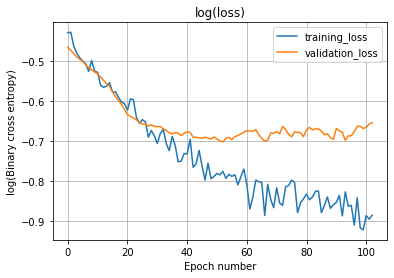

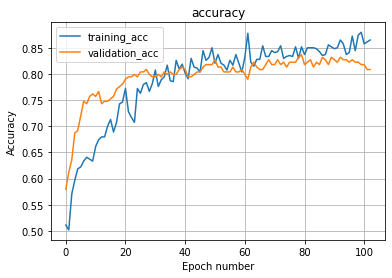

In [ ]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(np.log10(history.history['loss']), label="training_loss")
plt.plot(np.log10(history.history['val_loss']), label="validation_loss")
plt.title("log(loss)")
plt.ylabel("log(Binary cross entropy)")
plt.xlabel("Epoch number")
plt.grid()
plt.legend()

plt.figure()
plt.plot(history.history['binary_accuracy'], label="training_acc")
plt.plot(history.history['val_binary_accuracy'], label="validation_acc")
plt.title("accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch number")
plt.grid()
plt.legend()

""" plt.figure()
plt.plot(history.history['reg_output_mean_absolute_error'], label="training_mae")
plt.plot(history.history['val_reg_output_mean_absolute_error'], label="validation_mae")
plt.title("mae")
plt.ylabel("Accuracy")
plt.xlabel("Epoch number")
plt.grid()
plt.legend() """

print(f"min val_loss = {np.round(np.amin(history.history['val_loss']), 4)}")
print(f"max val_acc = {np.round(np.amax(history.history['val_binary_accuracy']), 3)}")

In [ ]:
"""
    Validation set
"""

pred = model.predict(x_val)
y_pred = pred[:,0]
y_true = y_val

thr = 0.5

y_pred_b = y_pred >= thr
acc = np.sum(y_pred_b == y_true) / y_pred_b.shape[0]
print(f"Accuracy (validation set): {np.round(acc*100, 1)}")

data = np.stack([y_pred[0:20], y_true[0:20]]).T
print(tabulate(data, headers=["y_pred", "y_true"]))

7/7 [==============================] - 1s 90ms/step
Accuracy (validation set): 81.3
   y_pred    y_true
---------  --------
0.954996          1
0.104937          0
0.450218          1
0.981533          1
0.979089          1
0.885886          1
0.348771          1
0.946408          1
0.990406          1
0.369778          1
0.0446832         1
0.55868           0
0.983691          1
0.0330858         0
0.981264          1
0.186235          1
0.887363          1
0.417363          0
0.912891          1
0.598441          1


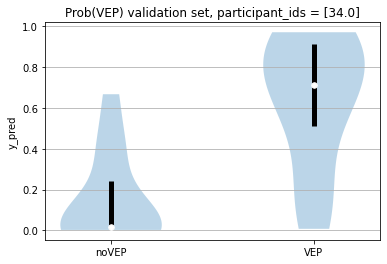

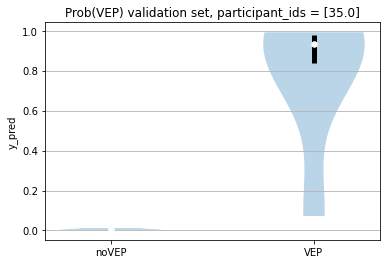

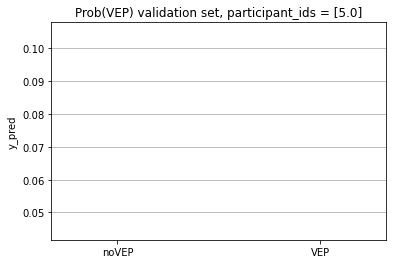

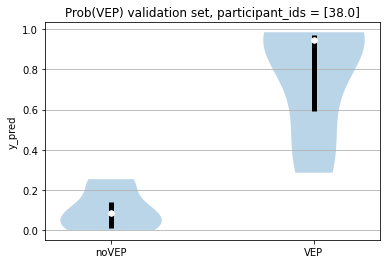

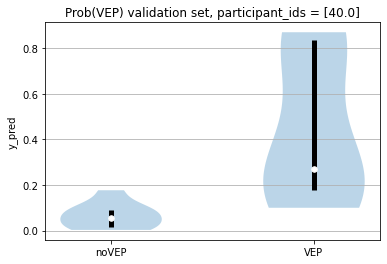

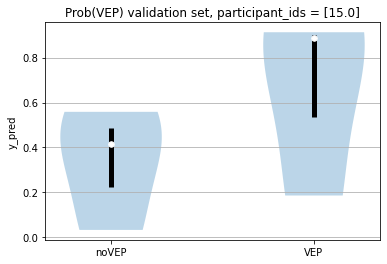

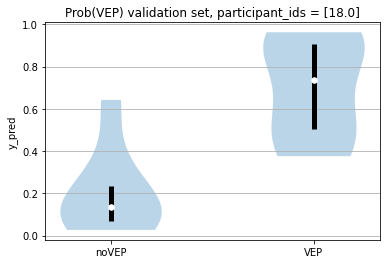

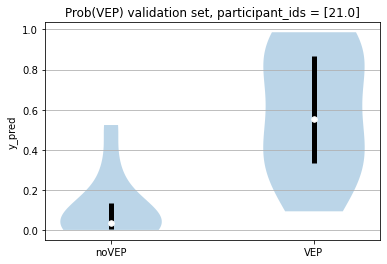

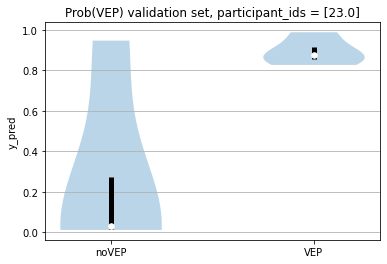

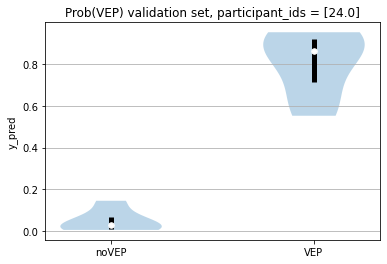

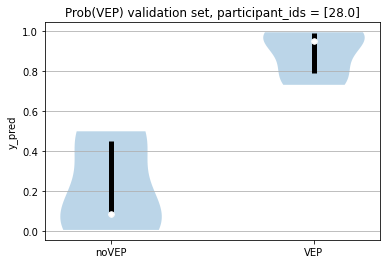

In [ ]:
"""
    Examine predicted probabilities
"""

def plot_violin(y_pred, y_true, ids, participant_ids):
    id_mask = np.zeros(ids.shape, dtype=bool)
    for pid in participant_ids:
        id_mask = np.logical_or(ids == pid, id_mask)

    y_pred_id, y_true_id = y_pred[id_mask], y_true[id_mask]
    y_pred_pos = y_pred_id[y_true_id == 1]
    y_pred_neg = y_pred_id[y_true_id == 0]

    n_neg = y_pred_neg.shape[0]
    n_pos = y_pred_pos.shape[0]
    if n_neg > n_pos:
        y_pred_neg = y_pred_neg[(n_neg - n_pos):]

    else:
        y_pred_pos = y_pred_pos[(n_pos - n_neg):]

    if n_neg == 0 or n_pos == 0:
        return

    D_y_pred = [y_pred_neg, y_pred_pos]

    quartile1, medians, quartile3 = np.percentile(D_y_pred, [25, 50, 75], axis=1)

    inds = np.arange(1, len(medians) + 1)

    inds = np.arange(1, len(medians) + 1)
    plt.figure()
    plt.violinplot(D_y_pred, showextrema=False)
    plt.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    plt.grid(axis="y")
    #plt.ylim((0,1))

    ticks = [1, 2]
    labels = ["noVEP", "VEP"]
    plt.xticks(ticks, labels)
    plt.ylabel("y_pred")
    plt.title(f"Prob(VEP) validation set, participant_ids = {participant_ids}")

tmp = ids_val.tolist()
ids_set = set(tmp)

for pid in ids_set:
    plot_violin(y_pred, y_true, ids_val, [pid])

In [ ]:
colors = ["red", "blue"]
plt.figure()
mask = y_true == 1
plt.scatter(t_true[mask], t_pred[mask], s=1)
plt.xlabel("t_true")
plt.ylabel("t_pred")


plt.plot([-500, 0], [-500,0], "--", color = "gray", alpha=0.7)

NameError: name 't_true' is not defined

<Figure size 432x288 with 0 Axes>